In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import Ridge
from tabulate import tabulate
from sklearn.linear_model import SGDRegressor
import warnings
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous
import time
import sys, os
from sklearn.metrics import make_scorer

path = 'datasets/Dataset_2.xlsx'

# Read and load dataset
df= pd.read_excel(path, sheet_name="preproc")


/home/ubuntu/Desktop/Demetra/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INPUT DATA

In [2]:
X = (df.iloc[:,14:]).values
print(X.shape)

(2905, 530)


OUTPUT DATA

In [3]:
Y = (df.iloc[:,7]).values
print(Y.shape)

(2905,)


RIDGE REGRESSION with closed form solution

In [ ]:
mlflow.set_experiment("Ridge Cholesky NITROGEN")
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
import sys, os

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [0.25, 0.5, 0.75]
results = []  
fig, axs = plt.subplots(5, 2,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle("Ridge Cholesky NITROGEN NRMSEPiqr"+"\n")
axs = axs.flatten()
# create 5x2 subfigs
fig, axs = plt.subplots(5, 2,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('Ridge Cholesky NITROGEN test'+"\n")
axs = axs.flatten()
k = 0

for ripartition in ripartisions:

    '''PARAM 1'''

    MSE_param1 = []

    best_MSE_1 = 100000000
    best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}

    run_name = str(ripartition) + " ripartition"
    print(run_name)
    with mlflow.start_run(run_name=run_name):
        mlflow.log_param('ripartition', ripartition)
        i = 0
        for i in range(trials):
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
            param_grid = {'alpha': Continuous(1/100000,0.01)}
            ridge_reg_cl = Ridge(solver="cholesky")
            
            evolved_estimator = GASearchCV(estimator=ridge_reg_cl,
                                  cv=5,
                                  scoring='neg_mean_squared_error',
                                  param_grid=param_grid,
                                  n_jobs=-1,
                                  verbose=True,
                                  population_size=10,
                                  generations=10)
    
            evolved_estimator.fit(X_train, Y_train)
    
            # Make predictions using the testing set
            Y_pred_ridge_cl =  evolved_estimator.predict(X_test)
    
            #save MSE of the first parameters
            MSE_param1.append(mean_squared_error(Y_test, Y_pred_ridge_cl))
    
            #check if this is the best model in terms of MSE
            if MSE_param1[-1] < best_MSE_1:
              best_MSE_1 = MSE_param1[-1]
              best_data_1["Y_test"] = Y_test
              best_data_1["Y_pred"] = Y_pred_ridge_cl
              best_data_1["alpha"] =  float(evolved_estimator.best_params_["alpha"])
              best_data_1["seed"] = seeds[i]
        
        mlflow.log_metric("Best_MSE", best_MSE_1)
        mlflow.log_metric("Mean_MSE", np.mean(MSE_param1))
        mlflow.log_metric("Var_MSE", np.var(MSE_param1))
        mlflow.log_metric("alpha", best_data_1["alpha"])
    


    results.append([str(ripartition *100 ), str(best_MSE_1),
                    (np.mean(MSE_param1)), str(np.var(MSE_param1)),
                    str(best_data_1["alpha"]),best_data_1["seed"]])

    '''PLOT THE BEST MODELS'''
    axs[k].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
    axs[k].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
    axs[k].legend()
    axs[k].set_xlabel("Actual values")
    axs[k].set_ylabel("Predicted value")
    axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "BEST MSE: " + str(min(MSE_param1)) )
    k += 1


'''SHOW RESULTS'''

headers = ["Test size(%)", "Best(MSE)", "Mean(MSE)", "Var(MSE)","Seed"]

print(tabulate(results, headers,  tablefmt="double_outline"))



**RIDGE REGRESSION with closed form solution NRMSEPiqr**

0.25 ripartition
Trial: 1
gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	10    	-0.378541	0.0315117  	-0.323532  	-0.423689  
1  	20    	-0.412624	0.00364372 	-0.408481  	-0.417473  
2  	20    	-0.413523	0.00305544 	-0.409884  	-0.417473  
3  	20    	-0.41509 	0.00439223 	-0.4037    	-0.419017  
4  	20    	-0.414643	0.0091965  	-0.387648  	-0.42156   
5  	20    	-0.419034	0.00226309 	-0.415412  	-0.422516  
6  	20    	-0.419435	0.00328745 	-0.4118    	-0.42363   
7  	20    	-0.414847	0.0163243  	-0.366332  	-0.423846  
8  	20    	-0.42074 	0.00318669 	-0.412864  	-0.423846  
9  	20    	-0.412565	0.0172482  	-0.366049  	-0.423905  
10 	20    	-0.416929	0.00703241 	-0.405321  	-0.423905  
Trial: 2
gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	10    	-0.395718	0.0313123  	-0.335373  	-0.430451  
1  	20    	-0.426374	0.00760296 	-0.407107  	-0.432203  
2  	20    	-0.428939	0.00278392 	-0.422794  	-0.432203  
3  	20    	-0.425025	0.00948783 	-0.40499   	-0.43220

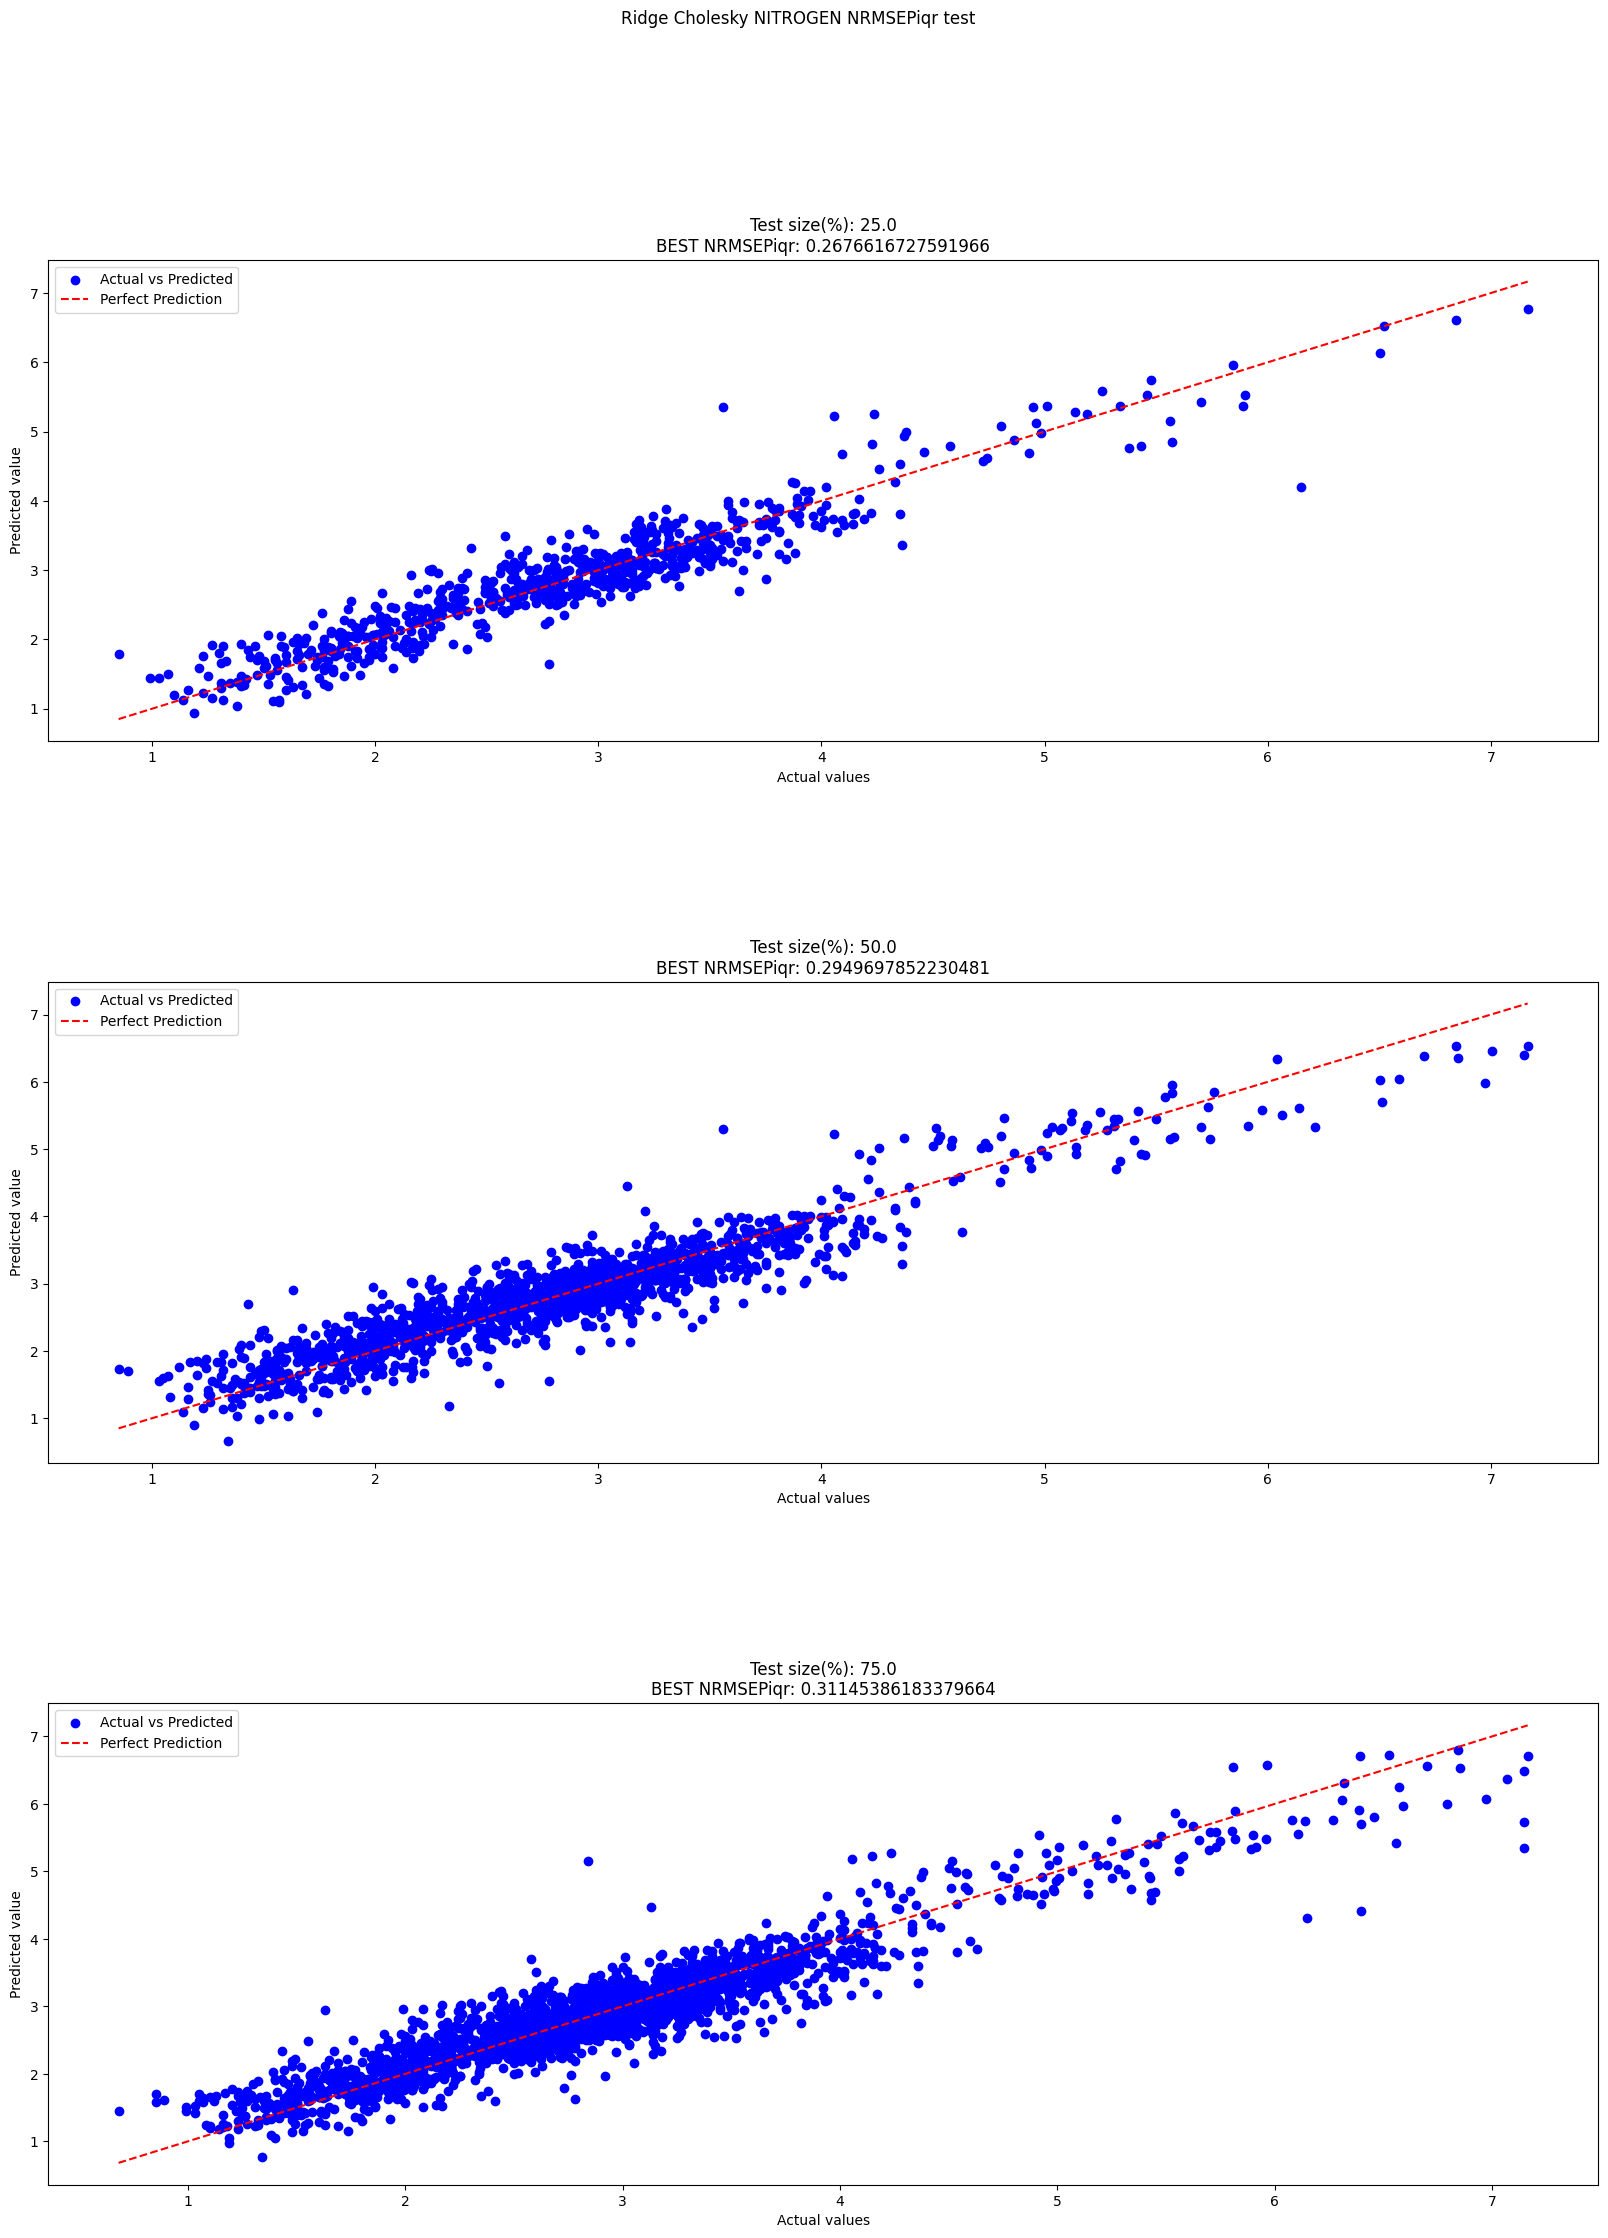

In [4]:


def NRMSEPiqr(observed_values, predicted_values):
    # Calculate RMSEP
    rmsep = np.sqrt(np.mean((observed_values - predicted_values) ** 2))
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(observed_values, 25)
    Q3 = np.percentile(observed_values, 75)

    # Calculate IQR
    IQR = Q3 - Q1

    return rmsep/IQR

NRMSEPiqrscorer = make_scorer(NRMSEPiqr,greater_is_better=False)




if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [0.25,0.5,0.75]
results = []  

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('Ridge Cholesky NITROGEN NRMSEPiqr test'+"\n")
axs = axs.flatten()
k = 0

for ripartition in ripartisions:

        NRMSEP = []

        best_NRMSEP = 100000000
        best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}

        run_name = str(ripartition) + " ripartition"
        print(run_name)
        for i in range(trials):
            print("Trial:",i+1)
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
            param_grid = {'alpha': Continuous(1/100000,0.01)}
            ridge_reg_cl = Ridge(solver="cholesky")
            
            evolved_estimator = GASearchCV(estimator=ridge_reg_cl,
                                  cv=5,
                                  scoring=NRMSEPiqrscorer,
                                  param_grid=param_grid,
                                  n_jobs=-1,
                                  verbose=True,
                                  population_size=10,
                                  generations=10,
                                  criteria = "min")
            
            start_time = time.time()
            evolved_estimator.fit(X_train, Y_train)
            elapsed_time = (time.time() -start_time)/60 #elapsed time in minute
    
            # Make predictions using the testing set
            Y_pred_ridge_cl =  evolved_estimator.predict(X_test)
    
            #save NRMSEP of the first parameters
            NRMSEP.append(NRMSEPiqr(Y_test, Y_pred_ridge_cl))
    
            #check if this is the best model in terms of MSE
            if NRMSEP[-1] < best_NRMSEP:
              best_NRMSEP = NRMSEP[-1]
              best_data_1["Y_test"] = Y_test
              best_data_1["Y_pred"] = Y_pred_ridge_cl
              best_data_1["alpha"] =  float(evolved_estimator.best_params_["alpha"])
              best_data_1["seed"] = seeds[i]
              best_data_1["model"] = evolved_estimator.best_estimator_
              best_data_1["time"] = elapsed_time


        results.append([str(ripartition *100 ), str(best_NRMSEP),
                        (np.mean(NRMSEP)), str(np.var(NRMSEP)),
                        str(best_data_1["alpha"]),best_data_1["seed"],best_data_1["time"]])

        '''PLOT THE BEST MODELS'''
        axs[k].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
        axs[k].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                    [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
        axs[k].legend()
        axs[k].set_xlabel("Actual values")
        axs[k].set_ylabel("Predicted value")
        axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "BEST NRMSEPiqr: " + results[k][1] )
        k += 1


'''SHOW RESULTS'''

headers = ["Test size(%)", "Best(NRMSEPiqr)", "Mean(NRMSEPiqr)", "Var(NRMSEPiqr)","Seed","Time(min)"]

print(tabulate(results, headers,  tablefmt="double_outline"))



**RIDGE REGRESSION with SGD**

In [ ]:



if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [i/100 for i in range(5,55,5)]
results = [] 

# create 5x2 subfigs
fig, axs = plt.subplots(5, 2,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('Linear regression SGD NITROGEN test'+"\n")
axs = axs.flatten()
k = 0

for ripartition in ripartisions:

    '''PARAM 1'''

    MSE_param1 = []

    best_MSE_1 = 100000000
    best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}

    run_name = str(ripartition) + " ripartition"
    print(run_name)
    with mlflow.start_run(run_name=run_name):
        mlflow.log_param('ripartition', ripartition)
        i = 0
        for i in range(trials):
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
            param_grid = {'alpha': Continuous(1/100000,0.01)}
            ridge_reg_sgd = SGDRegressor(max_iter=5000, tol=1e-5, penalty="l2", eta0=0.01,
                                                n_iter_no_change=10, random_state=42)
    
            evolved_estimator = GASearchCV(estimator=ridge_reg_sgd,
                                  cv=5,
                                  scoring=NRMSEPiqrscorer,
                                  param_grid=param_grid,
                                  n_jobs=-1,
                                  verbose=True,
                                  population_size=10,
                                  generations=10)
    
            evolved_estimator.fit(X_train, Y_train)
    
            # Make predictions using the testing set
            Y_pred_ridge_sgd =  evolved_estimator.predict(X_test)
    
            #save MSE of the first parameters
            MSE_param1.append(mean_squared_error(Y_test, Y_pred_ridge_sgd))
    
            #check if this is the best model in terms of MSE
            if MSE_param1[-1] < best_MSE_1:
              best_MSE_1 = MSE_param1[-1]
              best_data_1["Y_test"] = Y_test
              best_data_1["Y_pred"] = Y_pred_ridge_sgd
              best_data_1["alpha"] =  float(evolved_estimator.best_params_["alpha"])
              best_data_1["seed"] = seeds[i]


    results.append([str(ripartition *100 ), str(best_MSE_1),
     (np.mean(MSE_param1)), str(np.var(MSE_param1)), 
        str(best_data_1["alpha"]),str(best_data_2["alpha"]),
                    best_data_1["seed"],best_data_2["seed"]])

    '''PLOT THE BEST MODELS'''
    axs[k].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
    axs[k].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
    axs[k].set_title("Best MSE results" + "\n" + f"Test size(%): {ripartition * 100}")
    axs[k].legend()
    axs[k].set_xlabel("Actual values")
    axs[k].set_ylabel("Predicted value")
    axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "MSE: " + str(min(MSE_param1)) )
    k += 1


'''SHOW RESULTS'''

headers = ["Test size(%)", "Best(MSE)", "Mean(MSE)", "Var(MSE)","Seed"]

print(tabulate(results, headers,  tablefmt="double_outline"))



**RIDGE REGRESSION with SGD NRMSEPiqr**

0.25 ripartition
Trial:  1
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	-0.72382	0.0199719  	-0.691871  	-0.751782  
1  	20    	-0.739404	0.0130788  	-0.705317  	-0.751782  
2  	20    	-0.747893	0.00423211 	-0.737777  	-0.751796  
3  	20    	-0.743856	0.0127662  	-0.706458  	-0.751782  
4  	20    	-0.748769	0.00221262 	-0.74503   	-0.751782  
5  	20    	-0.750378	0.00164855 	-0.74797   	-0.751782  
6  	20    	-0.750236	0.0019201  	-0.747092  	-0.751782  
7  	20    	-0.750353	0.00284475 	-0.742332  	-0.751782  
8  	20    	-0.750097	0.00138074 	-0.748721  	-0.751782  
9  	20    	-0.750523	0.00285132 	-0.742365  	-0.751782  
10 	20    	-0.751454	0.000861236	-0.748875  	-0.751782  
Trial:  2
gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	10    	-0.729202	0.0178972  	-0.687679  	-0.744792  
1  	20    	-0.738604	0.0116499  	-0.716999  	-0.750389  
2  	20    	-0.745699	0.00471156 	-0.739364  	-0.75194   
3  	20    	-0.748477	0.00360775 	-0.742961  	-0.75218

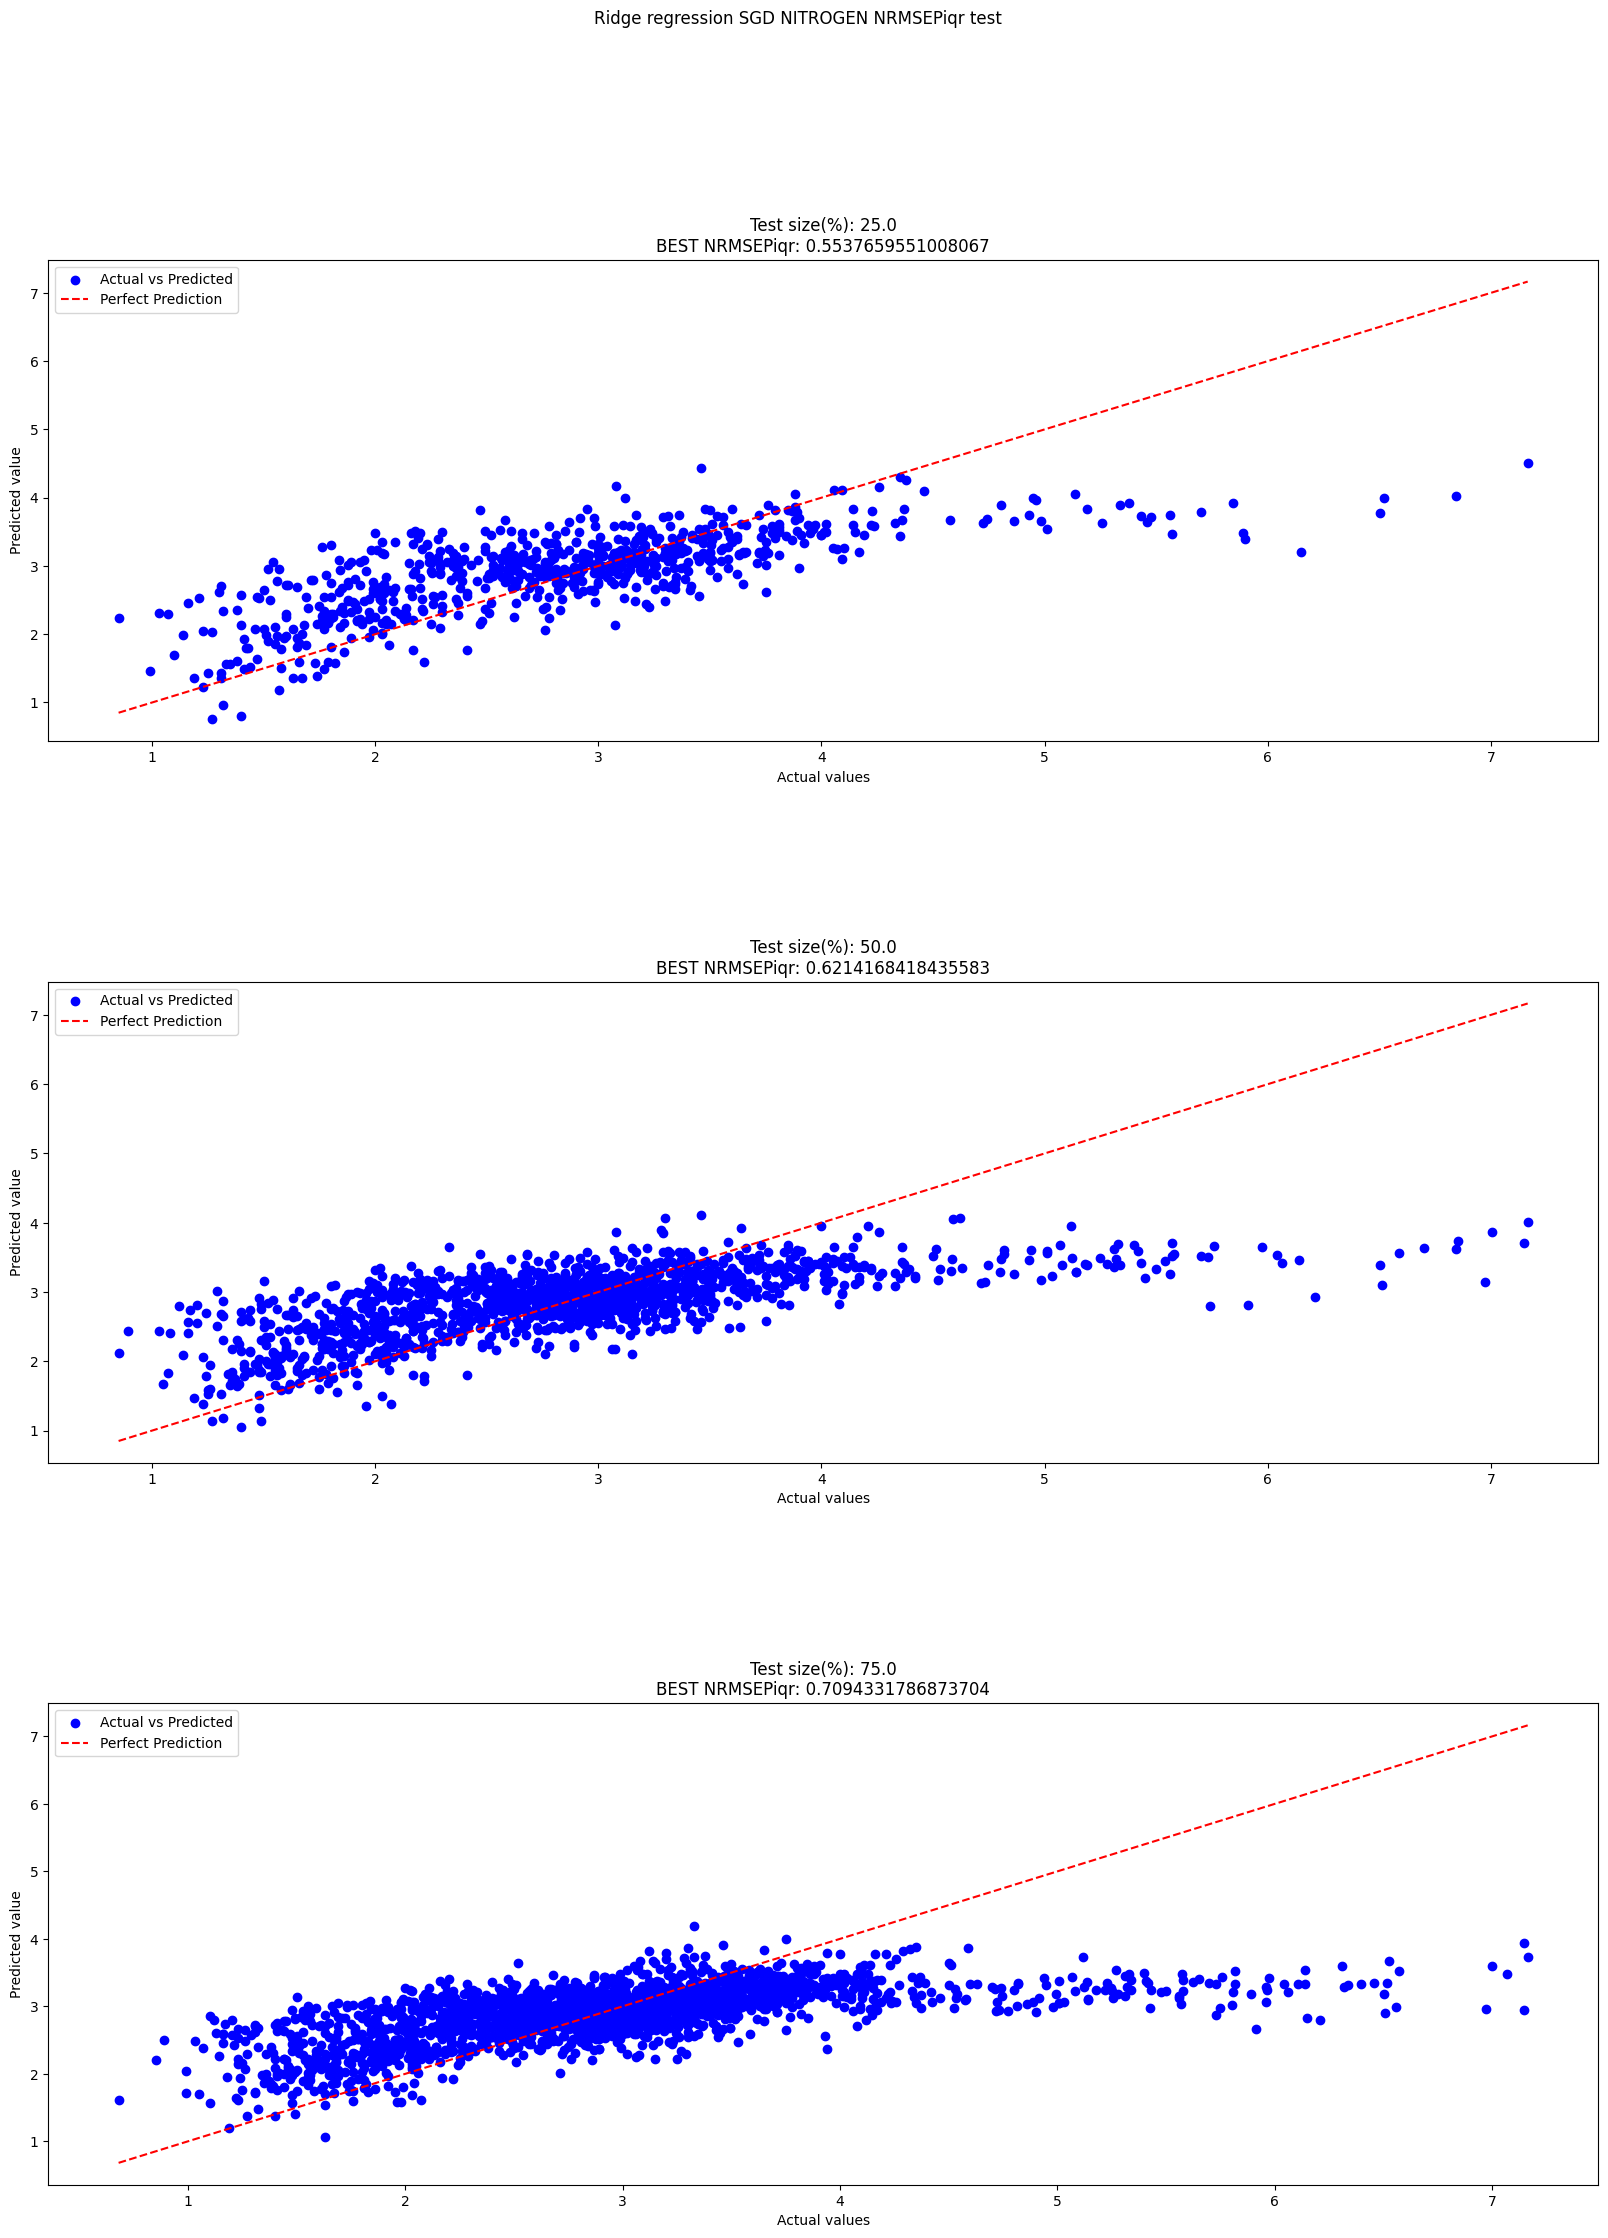

In [6]:


if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 


def NRMSEPiqr(observed_values, predicted_values):
    # Calculate RMSEP
    rmsep = np.sqrt(np.mean((observed_values - predicted_values) ** 2))
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(observed_values, 25)
    Q3 = np.percentile(observed_values, 75)

    # Calculate IQR
    IQR = Q3 - Q1

    return rmsep/IQR

NRMSEPiqrscorer = make_scorer(NRMSEPiqr,greater_is_better=False)


#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [0.25, 0.5, 0.75]
results = [] 

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('Ridge regression SGD NITROGEN NRMSEPiqr test'+"\n")
axs = axs.flatten()
k = 0

for ripartition in ripartisions:



        NRMSEP = []

        best_NRMSEP = 100000000
        best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}

        run_name = str(ripartition) + " ripartition"
        print(run_name)
  
        i = 0
        for i in range(trials):
            print("Trial: ", i+1)
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
            param_grid = {'alpha': Continuous(1/100000,0.01)}
            ridge_reg_sgd = SGDRegressor(max_iter=5000, tol=1e-5, penalty="l2", eta0=0.01,
                                                n_iter_no_change=10, random_state=42)
    
            evolved_estimator = GASearchCV(estimator=ridge_reg_sgd,
                                  cv=5,
                                  scoring=NRMSEPiqrscorer,
                                  param_grid=param_grid,
                                  n_jobs=-1,
                                  verbose=True,
                                  population_size=10,
                                  generations=10,
                                  criteria = "min")
    
            start_time = time.time()
            evolved_estimator.fit(X_train, Y_train)
            elapsed_time = (time.time() -start_time)/60 #elapsed time in minute
    
            # Make predictions using the testing set
            Y_pred_ridge_sgd =  evolved_estimator.predict(X_test)
    
            #save MSE of the first parameters
            NRMSEP.append(NRMSEPiqr(Y_test, Y_pred_ridge_sgd))
    
            #check if this is the best model in terms of MSE
            if NRMSEP[-1] < best_NRMSEP:
                best_NRMSEP = NRMSEP[-1]
                best_data_1["Y_test"] = Y_test
                best_data_1["Y_pred"] = Y_pred_ridge_sgd
                best_data_1["alpha"] = float(evolved_estimator.best_params_["alpha"])
                best_data_1["seed"] = seeds[i]
                best_data_1["model"] = evolved_estimator.best_estimator_
                best_data_1["time"] = elapsed_time

        results.append([str(ripartition *100 ), str(best_NRMSEP),
                        (np.mean(NRMSEP)), str(np.var(NRMSEP)),
                        str(best_data_1["alpha"]),best_data_1["seed"],best_data_1["time"]])

        '''PLOT THE BEST MODELS'''
        axs[k].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
        axs[k].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                    [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
        axs[k].legend()
        axs[k].set_xlabel("Actual values")
        axs[k].set_ylabel("Predicted value")
        axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "BEST NRMSEPiqr: " + results[k][1] )
        k += 1


'''SHOW RESULTS'''

headers = ["Test size(%)", "Best(NRMSEPiqr)", "Mean(NRMSEPiqr)", "Var(NRMSEPiqr)","alpha","Seed","Time"]

print(tabulate(results, headers,  tablefmt="double_outline"))


